In [2]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# import tidynamics as td

## Load and inspect the data

In [4]:
traj = md.load('data/traj_3.xtc',top= 'data/water_top.pdb')
com = md.compute_center_of_mass(traj)
com.shape

In [7]:
df = pd.DataFrame(com, columns=['1', '2', '3'])
df['t'] = traj.time/1000

df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['1', '2', '3'], var_name='coord', )

df_melt.head()

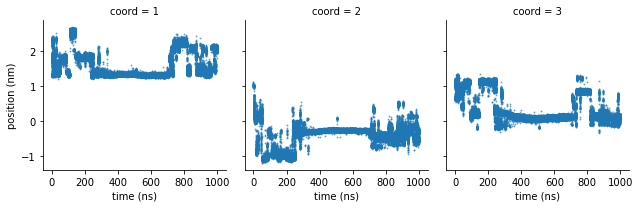

In [10]:
g = sns.FacetGrid(df_melt.iloc[::100,:], col='coord')
g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
g.set_axis_labels('time (ns)', 'position (nm)')

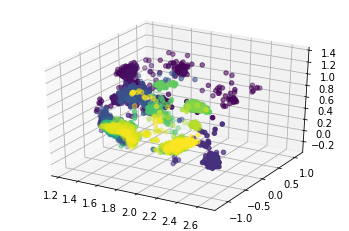

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])

## Choose MSM Parameters

We're going to use TICA both re-orient the axes for presentation purposes and as a pre-processing step for MSM construction. Some inital analysis with tica lags of 100ps and 50ps showed different behaviour (osccilations and no osciliations) in some parts of the trajectory (around the 110 - 140ns portion, in particular around 132ns). 

The process for choosing the TICA and MSM lag times will be to make a range of discrete trajectories using small TICA lag times and then look at the implied timescale plots, choose an MSM lag time and use CV to choose the TICA lag time.  

### Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [54]:
dt = traj.timestep/1000 # in ns
window = 1 # window size in ns
n_frames = int(window/dt) # number of frames in a window
n_splits = com.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(com, n_splits) # the split up 

### Setup hyperparameters

In [60]:
# The tica lags to try
tica_lags_ps = np.logspace(np.log10(5), np.log10(100), 10).astype(int)
tica_lags = (tica_lags_ps/traj.timestep).astype(int)
print(tica_lags_ps)

# number of dimensions to keep
ndim = 3

# The data to investigate
trajs = traj_split[132:136]

# number of clusters
n_clusters = int(np.sqrt(n_frames*len(trajs)))
print(n_clusters)

[  5   6   9  13  18  26  36  51  71 100]
199


### Fit ITS plots

In [61]:
# Fit tica and get tica trajs
tica_trajs = [coor.tica(trajs, lag=tica_lag, dim=ndim,  kinetic_map=True).get_output() for tica_lag in tica_lags]

# Cluster using kmeans
dtrajs = [coor.cluster_kmeans(trajs, k=n_clusters).dtrajs for trajs in tica_trajs]

# get implied timescale plots
itss = [msm.its(dtraj, lags = tica_lags) for dtraj in dtrajs]

29-03-19 13:59:32 pyemma.coordinates.clustering.kmeans.KmeansClustering[170] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:34 pyemma.coordinates.clustering.kmeans.KmeansClustering[172] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:37 pyemma.coordinates.clustering.kmeans.KmeansClustering[174] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:39 pyemma.coordinates.clustering.kmeans.KmeansClustering[176] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:43 pyemma.coordinates.clustering.kmeans.KmeansClustering[180] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:45 pyemma.coordinates.clustering.kmeans.KmeansClustering[182] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:48 pyemma.coordinates.clustering.kmeans.KmeansClustering[184] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


29-03-19 13:59:52 pyemma.coordinates.clustering.kmeans.KmeansClustering[188] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


### Plot ITS

In [72]:
?mplt.plot_implied_timescales

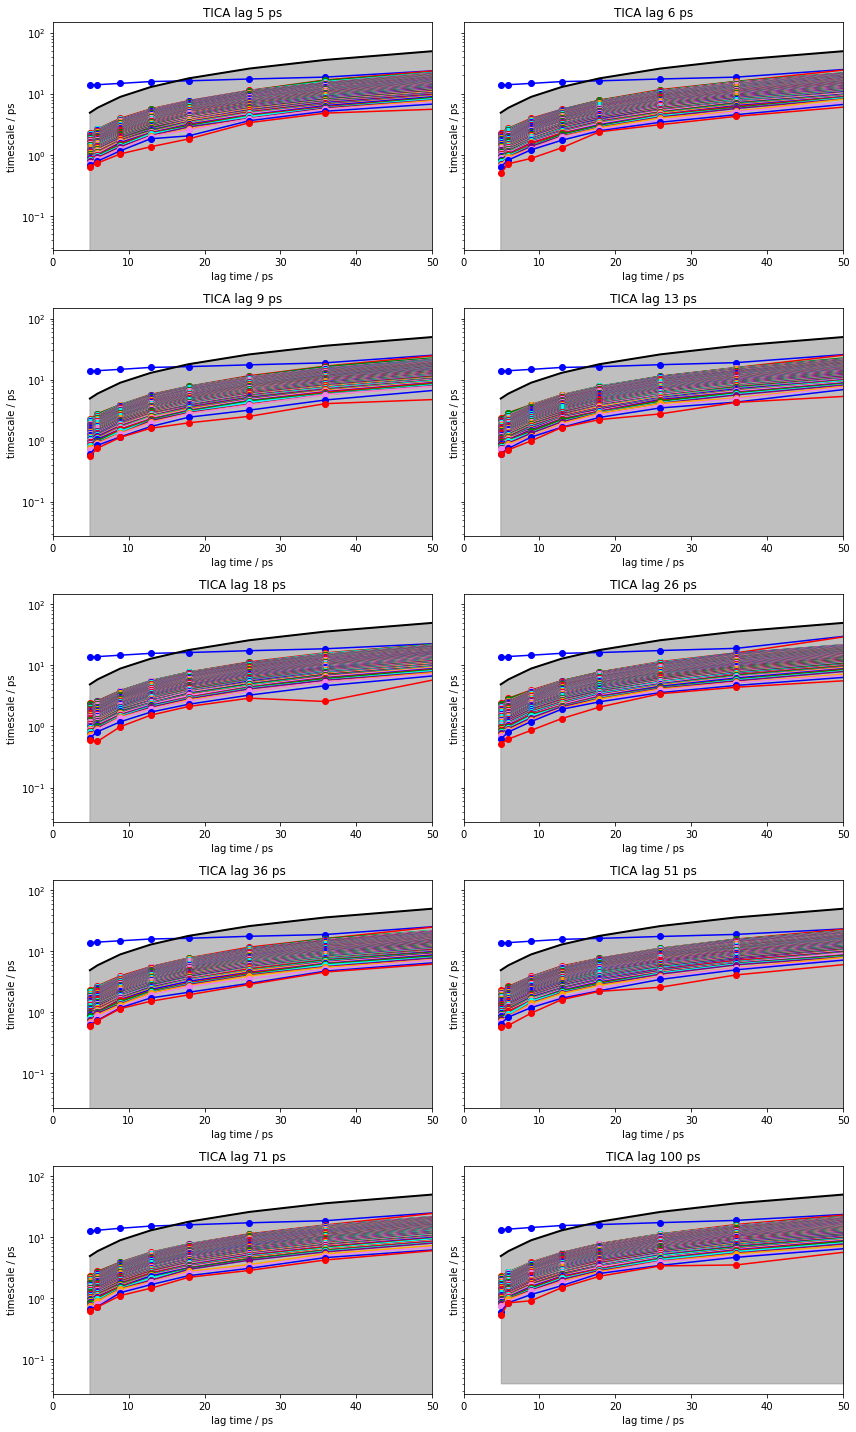

In [74]:
n_rows = len(itss)//2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols,  figsize=(6*n_cols, 4*n_rows ), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    mplt.plot_implied_timescales(itss[i], ax=ax, ylog=True, units='ps', dt=dt*1000, marker='o')
    ax.set_title('TICA lag {} ps'.format(tica_lags_ps[i]))
    ax.tick_params(labelbottom=True)
    ax.set_xlim(0, 50)
              
plt.tight_layout()

So the MSM lag time seems to be 9ps. So let's score MSMs using a lag of 9ps and choose the tica lag time less than that (it doesn't make sense to make it longer than that. 

### Fit and score MSMs

In [75]:
msms = [msm.estimate_markov_model(dtraj, lag=tica_lags[2]) for dtraj in dtrajs]

In [76]:
scores = np.vstack([msms[i].score_cv(dtrajs[i], n=10, score_k=2) for i in range(len(dtrajs))])

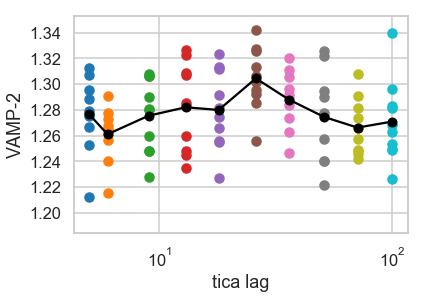

In [91]:
with sns.plotting_context('talk'):
    for i, score in enumerate(scores): plt.scatter(np.repeat(tica_lags_ps[i], scores.shape[1]), score)
    plt.plot(tica_lags_ps, np.mean(scores, axis=1),color='k', marker='o')
    plt.xscale('log')
    plt.xlabel('tica lag')
    plt.ylabel('VAMP-2')
    sns.set_style('darkgrid')

So the MSM lag is 9ps (let's call it 10ps for nice round numbers)
Although the VAMP scores are higher for large lags, it doesn't make sense to choose TICA lag > MSM lag.  So we'll choose TICA lag of 5ps. 

## Example plots

In [93]:
tica_lag = int(5/traj.timestep)
msm_lag = int(10/traj.timestep)

In [102]:
tica_objs = [coor.tica(traj, lag=tica_lag, dim=3,  kinetic_map=False) for traj in traj_split]
tica_km_objs = [coor.tica(traj, lag=tica_lag, dim=3,  kinetic_map=True) for traj in traj_split]

tica_trajs = [x.get_output()[0] for x in tica_objs]
tica_km_trajs = [x.get_output()[0] for x in tica_km_objs]

tica_vecs = [x.eigenvectors for x in tica_objs]
tica_vals = [x.eigenvalues for x in tica_objs]


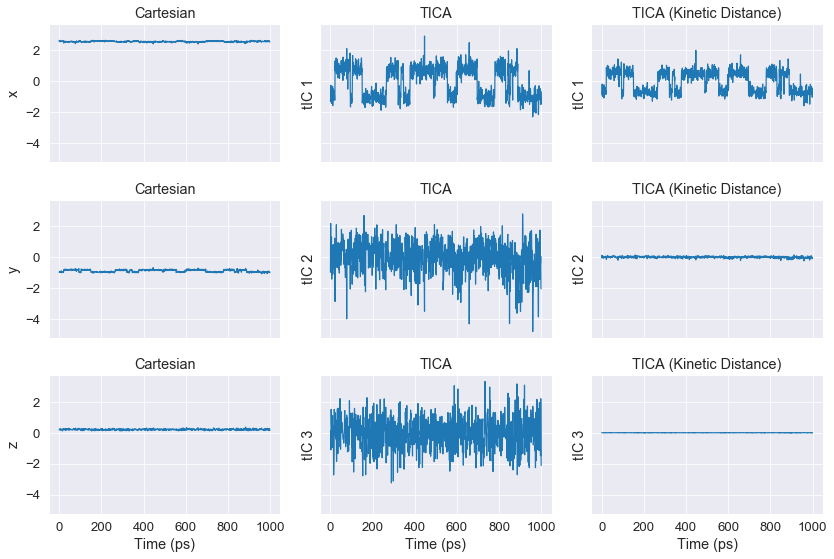

In [105]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12,8))
    idx = 132
    stride = 10
    time = np.arange(traj_split[idx][::stride].shape[0])*traj.timestep*stride

    xyz_labs = ['x', 'y', 'z']
    tica_labs = ['tIC {}'.format(i+1) for i in range(3)]

    for i, ax in enumerate(axes[:,0]):
        ax.plot(time, traj_split[idx][::stride, i])
        ax.set_ylabel(xyz_labs[i])
        ax.set_title('Cartesian')
        if i == 2: ax.set_xlabel('Time (ps)')

    for i, ax in enumerate(axes[:,1]):
        ax.plot(time, tica_trajs[idx][::stride, i])
        ax.set_ylabel(tica_labs[i])
        ax.set_title('TICA')
        if i == 2: ax.set_xlabel('Time (ps)')
            
    for i, ax in enumerate(axes[:,2]):
        ax.plot(time, tica_km_trajs[idx][::stride, i])
        ax.set_ylabel(tica_labs[i])
        ax.set_title('TICA (Kinetic Distance)')
        if i == 2: ax.set_xlabel('Time (ps)')

    # _ = [ax.plot(traj[:,i]) for j, traj in enumerate(com_split[:2]) for i, ax in enumerate(axes[:3,j])]
    # _ = [ax.plot(traj[:,i]) for j, traj in enumerate(tica_trajs[:2]) for i, ax in enumerate(axes[3:,j])]

    plt.tight_layout()

## Plot entire trajectory

In [107]:
# Split up into 10 lots of 10
trajs = np.concatenate(tica_km_trajs)
trajs = np.insert(trajs, 3, np.arange(trajs.shape[0])*dt, axis=1)
trajs_split = np.array_split(trajs, 10)
trajs_split = [np.array_split(trajs, 10) for trajs in trajs_split]



tic=0
count = 1
for segs in trajs_split:
    with sns.plotting_context('paper'):
        sns.set_style('darkgrid')
        fig, axes = plt.subplots(10, figsize=(8.27, 11.7), sharey=True, sharex=False)
        for i, traj in enumerate(segs):
            axes[i].scatter(traj[::20, -1], traj[::20, tic], alpha=0.5, s=1)
            axes[i].set_ylabel('tIC {}'.format(tic+1))
#             axes[i].set_ylim(-2,2)
        plt.tight_layout()
        plt.savefig('images/traj-3-tic_{0}-part_{1}-t_lag_{2}.png'.format(tic+1, count, tica_lag))
        plt.close()
    count += 1


In [108]:
!pip install dill

In [ ]:
import dill
dill.dump_session('msm_parameters-29-03-2019.db')
